In [34]:
from PIL import Image, ImageOps
import cv2
import numpy as np

import random
import matplotlib.pyplot as plt
import copy

### Connected Component Labelling

In [2]:
def colourize(img):
    height, width = img.shape

    colors = []
    colors.append([])
    colors.append([])
    color = 1
    # Displaying distinct components with distinct colors
    coloured_img = Image.new("RGB", (width, height))
    coloured_data = coloured_img.load()

    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] > 0:
                if img[i][j] not in colors[0]:
                    colors[0].append(img[i][j])
                    colors[1].append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

                ind = colors[0].index(img[i][j])
                coloured_data[j, i] = colors[1][ind]

    return coloured_img


In [3]:
def binarize(img_array, threshold=130):
    for i in range(len(img_array)):
        for j in range(len(img_array[0])):
            if img_array[i][j] > threshold:
                img_array[i][j] = 0
            else:
                img_array[i][j] = 1
    return img_array

In [4]:
def ccl4(img_array):
    ##### first pass #####
    print("starting first pass")
    curr_label = 1;
    img_array = np.array(img_array)
    labels = np.array(img_array)

    # storing label conversions
    label_conv = []
    label_conv.append([])
    label_conv.append([])

    count = 0
    for i in range(1, len(img_array)):
        for j in range(1, len(img_array[0])):

            if img_array[i][j] > 0:
                label_x = labels[i][j - 1]
                label_y = labels[i - 1][j]

                if label_x > 0:
                    # both x and y have a label
                    if label_y > 0:

                        if not label_x == label_y:
                            labels[i][j] = min(label_x, label_y)
                            if max(label_x, label_y) not in label_conv[0]:
                                label_conv[0].append(max(label_x, label_y))
                                label_conv[1].append(min(label_x, label_y))
                            elif max(label_x, label_y) in label_conv[0]:
                                ind = label_conv[0].index(max(label_x, label_y))
                                if label_conv[1][ind] > min(label_x, label_y):
                                    l = label_conv[1][ind]
                                    label_conv[1][ind] = min(label_x, label_y)
                                    while l in label_conv[0] and count < 100:
                                        count += 1
                                        ind = label_conv[0].index(l)
                                        l = label_conv[1][ind]
                                        label_conv[1][ind] = min(label_x, label_y)

                                    label_conv[0].append(l)
                                    label_conv[1].append(min(label_x, label_y))

                        else:
                            labels[i][j] = label_y
                    # only x has a label
                    else:
                        labels[i][j] = label_x

                # only y has a label
                elif label_y > 0:
                    labels[i][j] = label_y

                # neither x nor y has a label
                else:
                    labels[i][j] = curr_label
                    curr_label += 1

                    ##### second pass #####
    print("starting second pass")
    count = 1
    for idx, val in enumerate(label_conv[0]):

        if label_conv[1][idx] in label_conv[0] and count < 100:
            count += 1
            ind = label_conv[0].index(label_conv[1][idx])
            label_conv[1][idx] = label_conv[1][ind]

    for i in range(1, len(labels)):
        for j in range(1, len(labels[0])):

            if labels[i][j] in label_conv[0]:
                ind = label_conv[0].index(labels[i][j])
                labels[i][j] = label_conv[1][ind]

    return labels


starting first pass
starting second pass


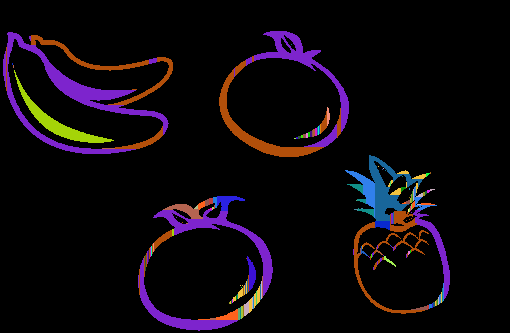

In [16]:


img_path = 'images/ccl_input.png'
img = Image.open(img_path)

#* Threshold the image
img = img.convert('L')
img = ImageOps.expand(img, border=1, fill='white')
img = np.array(img)
img = binarize(img)

img = ccl4(img)

#* Colour the image using labels
coloured_img = colourize(img)
coloured_img

### Histogram Equalization

In [19]:
img = cv2.imread('images/hist2.tif', 0)

In [20]:

#* Initialize intensity values with 256 zeroes
intensity_count = [0] * 256         

height,width = img.shape[:2]        
N = height * width   

In [21]:

#* Array for new_image
high_contrast = np.zeros(img.shape) 

In [22]:

#* Find pixels count for each intensity
for i in range(0,height):
    for j in range(0,width):
        intensity_count[img[i][j]] += 1     

In [23]:
L = 256

intensity_count,total_values_used = np.histogram(img.flatten(),L,[0,L])      
pdf_list = np.ceil(intensity_count*(L-1)/img.size)                      #* Calculate PDF
cdf_list = pdf_list.cumsum()                                            #* Calculate CDF

In [24]:
	
#* Apply the new intensities in our new image
for y in range(0, height):
    for x in range(0, width): 
        high_contrast[y,x] = cdf_list[img[y,x]]  

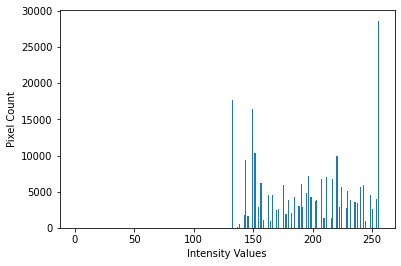

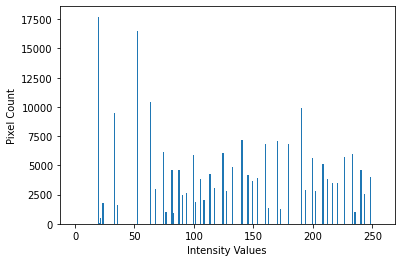

In [25]:

#* PLOT THE HISTOGRAMS
cv2.imwrite('images/high_contrast.png', high_contrast)                         

plt.hist(img.ravel(),256,[0,256])
plt.xlabel('Intensity Values')
plt.ylabel('Pixel Count')
plt.show()

plt.hist(high_contrast.ravel(),256,[0,256])	
plt.xlabel('Intensity Values')
plt.ylabel('Pixel Count')
plt.show()

### Local Histogram Analysis

In [27]:
img = cv2.imread("images/mountains.jpg", 0)

In [28]:
def slidingWindowEqualization(im, winSize):
    newImg = np.zeros((im.shape[0], im.shape[1]))
    for row in range(im.shape[0]-winSize+1):
        for col in range(im.shape[1]-winSize+1):
            newImg[row:row+winSize,col:col+winSize] = cv2.equalizeHist(im[row:row+winSize,col:col+winSize])
    return newImg

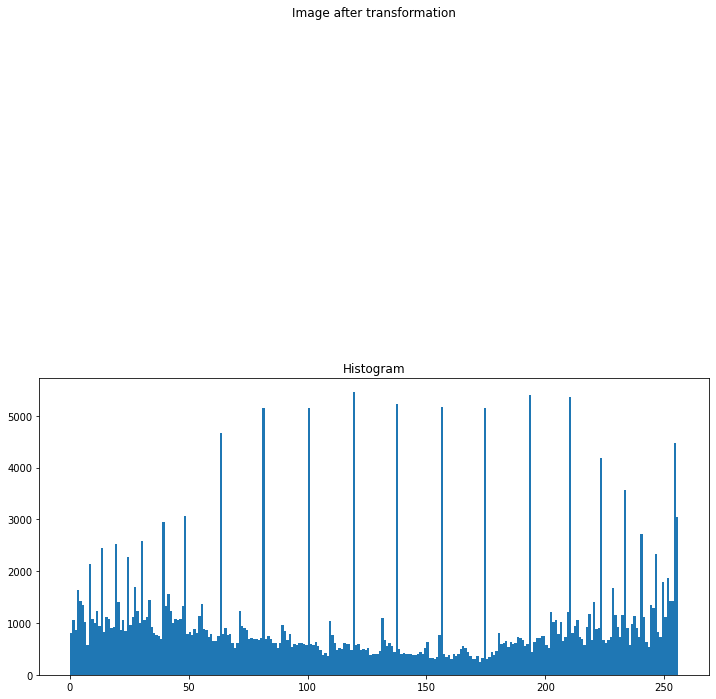

In [30]:
windowSize = 256
output_img = slidingWindowEqualization(img, windowSize)

# plt.figure(figsize = (12, 12))
plt.subplot(211)
plt.axis('off')
plt.title("Image after transformation")
# plt.imshow(output_img, cmap = "gray")

#* writing output image
cv2.imwrite("images/SlidingWindow.jpg", output_img)

plt.subplot(212)
plt.hist(output_img.ravel(),256,[0,256])
plt.title("Histogram")

plt.show()

### Sharpen Image

In [35]:
#reading image file
im = cv2.imread("images/sharpen_input.jpg", 1)

In [36]:
def sharpenFiltering(img):
    inputImg = copy.deepcopy(img.astype(np.float))
    #converting color scale from BGR to GRAY
    inputImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #initialize black image of size equal to given image
    outputImg = np.zeros(inputImg.shape)
    #padding the image with zeros
    inputImg = np.pad(inputImg, (1, 1), 'constant', constant_values=(0))
    #creating two filters for horizontal and vertical edge detection
    fh = np.array([[-1.0,-2.0,-1.0],[0.0,0.0,0.0],[1.0,2.0,1.0]])
    fy = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    #looping through image pixels
    for row in range(1, inputImg.shape[0]-1):
        for col in range(1, inputImg.shape[1]-1):
            dx, dy = 0.0, 0.0
            #convolving both filters
            for x_filter in range(3):
                for y_filter in range(3):
                    dx += inputImg[row+x_filter-1][col+y_filter-1]*fh[x_filter][y_filter]
                    dy += inputImg[row+x_filter-1][col+y_filter-1]*fy[x_filter][y_filter]
            
            #magnitude of gradient (instead of just adding dx and dy. we calculate magnitude)
            pixel = np.sqrt(dx * dx + dy * dy)
            outputImg[row-1][col-1] = pixel
    #normalizing pixels
    outputImg *= 255.0/np.max(outputImg)
    return outputImg

/tmp/ipykernel_14361/1375484869.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inputImg = copy.deepcopy(img.astype(np.float))


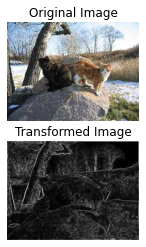

In [37]:
#applying sharpen filters
output = sharpenFiltering(im)
#writing image to image file
cv2.imwrite("images/sharpen_output.jpg",output)
#converting color scale from BGR to RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#plotting original image
plt.subplot(211)
plt.axis('off')
plt.title("Original Image")
plt.imshow(im)
#plotting transformed image
plt.subplot(212)
plt.axis('off')
plt.title("Transformed Image")
plt.imshow(output, cmap="gray")

plt.show()